# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            nn.Linear(hidden2_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        #x = self.flatten(x)
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 20, 20, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T,p,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 20, 20, 1)

# Loss Funktion; gibt Fehler an
loss_fn = nn.MSELoss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)


#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss = loss_fn(pred, y) # Calculate the loss
            loss += MRELoss(pred, y).item()

            # Record the correct predictions for training data
            _, predictions = torch.max(pred.data, 1)
            #train_correct += (predictions == y.data).sum()
            train_correct += (abs(predictions - y.data) <= 0.001).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f} \n")

    net.train()
    
    return acc, loss

#### Training

In [8]:
num_epochs = 100 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

#Optimierungsloop
for epoch in range(num_epochs):
    train_correct = 0
    train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        #loss = loss_fn(pred, y) # Calculate the loss
        loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients
        
#         # Record the correct predictions for training data
#         _, predictions = torch.max(pred.data, 1)
#         train_correct += (predictions == y.data).sum()                
#         train_total += predictions.size(0)    

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    net.eval() # Put the network into evaluation mode
    
    # Book keeping
    #train_loss.append(loss.item())
    
    # What was our train accuracy?
    train_acc, train_lost = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(train_acc)
    train_loss.append(train_lost)
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    test_acc, test_lost = check_accuracy(test_dataloader, net)
    test_accuracy.append(test_acc)
    test_loss.append(test_lost)   

#     loss = criterion(outputs, Variable(test_classes))
#     test_loss.append(loss.data[0])

Epoch 1/100, Iteration 1/25, Loss: 2.3257
Epoch 1/100, Iteration 2/25, Loss: 1.6231
Epoch 1/100, Iteration 3/25, Loss: 1.5382
Epoch 1/100, Iteration 4/25, Loss: 1.1559
Epoch 1/100, Iteration 5/25, Loss: 1.2952
Epoch 1/100, Iteration 6/25, Loss: 2.1390
Epoch 1/100, Iteration 7/25, Loss: 1.2683
Epoch 1/100, Iteration 8/25, Loss: 1.2994
Epoch 1/100, Iteration 9/25, Loss: 1.0925
Epoch 1/100, Iteration 10/25, Loss: 1.0624
Epoch 1/100, Iteration 11/25, Loss: 1.1523
Epoch 1/100, Iteration 12/25, Loss: 1.3246
Epoch 1/100, Iteration 13/25, Loss: 1.1450
Epoch 1/100, Iteration 14/25, Loss: 7.3584
Epoch 1/100, Iteration 15/25, Loss: 1.5150
Epoch 1/100, Iteration 16/25, Loss: 1.4466
Epoch 1/100, Iteration 17/25, Loss: 6.0355
Epoch 1/100, Iteration 18/25, Loss: 1.5022
Epoch 1/100, Iteration 19/25, Loss: 0.9509
Epoch 1/100, Iteration 20/25, Loss: 1.0079
Epoch 1/100, Iteration 21/25, Loss: 1.0546
Epoch 1/100, Iteration 22/25, Loss: 0.8762
Epoch 1/100, Iteration 23/25, Loss: 1.2398
Epoch 1/100, Iterati

Epoch 8/100, Iteration 19/25, Loss: 1.0993
Epoch 8/100, Iteration 20/25, Loss: 1.2707
Epoch 8/100, Iteration 21/25, Loss: 4.2088
Epoch 8/100, Iteration 22/25, Loss: 1.0374
Epoch 8/100, Iteration 23/25, Loss: 1.0239
Epoch 8/100, Iteration 24/25, Loss: 3.2401
Epoch 8/100, Iteration 25/25, Loss: 1.2756
Train Error: 
 Accuracy: 0.62%, Avg loss: 1.257094 

Test Error: 
 Accuracy: 1.5%, Avg loss: 1.875085 

Epoch 9/100, Iteration 1/25, Loss: 2.7838
Epoch 9/100, Iteration 2/25, Loss: 1.0615
Epoch 9/100, Iteration 3/25, Loss: 1.3251
Epoch 9/100, Iteration 4/25, Loss: 1.5432
Epoch 9/100, Iteration 5/25, Loss: 1.7648
Epoch 9/100, Iteration 6/25, Loss: 5.8523
Epoch 9/100, Iteration 7/25, Loss: 3.7568
Epoch 9/100, Iteration 8/25, Loss: 6.3401
Epoch 9/100, Iteration 9/25, Loss: 1.1132
Epoch 9/100, Iteration 10/25, Loss: 0.9595
Epoch 9/100, Iteration 11/25, Loss: 1.4947
Epoch 9/100, Iteration 12/25, Loss: 1.9783
Epoch 9/100, Iteration 13/25, Loss: 2.3281
Epoch 9/100, Iteration 14/25, Loss: 2.2209
Ep

Epoch 16/100, Iteration 12/25, Loss: 1.2297
Epoch 16/100, Iteration 13/25, Loss: 1.1799
Epoch 16/100, Iteration 14/25, Loss: 1.1725
Epoch 16/100, Iteration 15/25, Loss: 1.1944
Epoch 16/100, Iteration 16/25, Loss: 1.0018
Epoch 16/100, Iteration 17/25, Loss: 1.0294
Epoch 16/100, Iteration 18/25, Loss: 1.0301
Epoch 16/100, Iteration 19/25, Loss: 0.9404
Epoch 16/100, Iteration 20/25, Loss: 0.9799
Epoch 16/100, Iteration 21/25, Loss: 0.9631
Epoch 16/100, Iteration 22/25, Loss: 1.0429
Epoch 16/100, Iteration 23/25, Loss: 1.0841
Epoch 16/100, Iteration 24/25, Loss: 1.3728
Epoch 16/100, Iteration 25/25, Loss: 1.0591
Train Error: 
 Accuracy: 0.62%, Avg loss: 1.003492 

Test Error: 
 Accuracy: 1.5%, Avg loss: 1.036718 

Epoch 17/100, Iteration 1/25, Loss: 1.1012
Epoch 17/100, Iteration 2/25, Loss: 2.7034
Epoch 17/100, Iteration 3/25, Loss: 1.2419
Epoch 17/100, Iteration 4/25, Loss: 1.8562
Epoch 17/100, Iteration 5/25, Loss: 2.5592
Epoch 17/100, Iteration 6/25, Loss: 2.3844
Epoch 17/100, Iteratio

Train Error: 
 Accuracy: 0.62%, Avg loss: 1.505782 

Test Error: 
 Accuracy: 1.5%, Avg loss: 2.320180 

Epoch 24/100, Iteration 1/25, Loss: 1.2706
Epoch 24/100, Iteration 2/25, Loss: 1.0083
Epoch 24/100, Iteration 3/25, Loss: 1.0059
Epoch 24/100, Iteration 4/25, Loss: 0.9777
Epoch 24/100, Iteration 5/25, Loss: 0.9384
Epoch 24/100, Iteration 6/25, Loss: 1.0331
Epoch 24/100, Iteration 7/25, Loss: 1.1365
Epoch 24/100, Iteration 8/25, Loss: 1.0446
Epoch 24/100, Iteration 9/25, Loss: 0.8992
Epoch 24/100, Iteration 10/25, Loss: 1.7065
Epoch 24/100, Iteration 11/25, Loss: 4.3892
Epoch 24/100, Iteration 12/25, Loss: 0.9903
Epoch 24/100, Iteration 13/25, Loss: 1.4571
Epoch 24/100, Iteration 14/25, Loss: 1.8609
Epoch 24/100, Iteration 15/25, Loss: 5.5279
Epoch 24/100, Iteration 16/25, Loss: 3.2267
Epoch 24/100, Iteration 17/25, Loss: 1.3139
Epoch 24/100, Iteration 18/25, Loss: 2.3769
Epoch 24/100, Iteration 19/25, Loss: 1.1656
Epoch 24/100, Iteration 20/25, Loss: 6.2646
Epoch 24/100, Iteration 2

Train Error: 
 Accuracy: 0.62%, Avg loss: 2.026654 

Test Error: 
 Accuracy: 1.5%, Avg loss: 3.835944 

Epoch 31/100, Iteration 1/25, Loss: 1.2507
Epoch 31/100, Iteration 2/25, Loss: 1.5295
Epoch 31/100, Iteration 3/25, Loss: 4.4098
Epoch 31/100, Iteration 4/25, Loss: 1.0067
Epoch 31/100, Iteration 5/25, Loss: 0.9863
Epoch 31/100, Iteration 6/25, Loss: 1.5420
Epoch 31/100, Iteration 7/25, Loss: 2.7003
Epoch 31/100, Iteration 8/25, Loss: 2.2399
Epoch 31/100, Iteration 9/25, Loss: 6.7379
Epoch 31/100, Iteration 10/25, Loss: 2.5945
Epoch 31/100, Iteration 11/25, Loss: 1.6257
Epoch 31/100, Iteration 12/25, Loss: 1.2991
Epoch 31/100, Iteration 13/25, Loss: 1.0353
Epoch 31/100, Iteration 14/25, Loss: 1.0644
Epoch 31/100, Iteration 15/25, Loss: 1.9705
Epoch 31/100, Iteration 16/25, Loss: 0.9280
Epoch 31/100, Iteration 17/25, Loss: 1.9883
Epoch 31/100, Iteration 18/25, Loss: 1.1875
Epoch 31/100, Iteration 19/25, Loss: 1.0149
Epoch 31/100, Iteration 20/25, Loss: 1.0009
Epoch 31/100, Iteration 2

Epoch 38/100, Iteration 18/25, Loss: 2.7529
Epoch 38/100, Iteration 19/25, Loss: 2.4167
Epoch 38/100, Iteration 20/25, Loss: 1.3613
Epoch 38/100, Iteration 21/25, Loss: 1.8302
Epoch 38/100, Iteration 22/25, Loss: 1.3117
Epoch 38/100, Iteration 23/25, Loss: 1.2615
Epoch 38/100, Iteration 24/25, Loss: 1.3566
Epoch 38/100, Iteration 25/25, Loss: 1.1737
Train Error: 
 Accuracy: 0.62%, Avg loss: 1.009735 

Test Error: 
 Accuracy: 1.5%, Avg loss: 1.072789 

Epoch 39/100, Iteration 1/25, Loss: 0.9994
Epoch 39/100, Iteration 2/25, Loss: 1.9204
Epoch 39/100, Iteration 3/25, Loss: 1.0581
Epoch 39/100, Iteration 4/25, Loss: 1.0485
Epoch 39/100, Iteration 5/25, Loss: 0.9553
Epoch 39/100, Iteration 6/25, Loss: 1.0126
Epoch 39/100, Iteration 7/25, Loss: 1.0090
Epoch 39/100, Iteration 8/25, Loss: 1.0104
Epoch 39/100, Iteration 9/25, Loss: 0.9960
Epoch 39/100, Iteration 10/25, Loss: 1.5714
Epoch 39/100, Iteration 11/25, Loss: 1.0060
Epoch 39/100, Iteration 12/25, Loss: 1.0344
Epoch 39/100, Iteration 1

Epoch 46/100, Iteration 14/25, Loss: 1.2802
Epoch 46/100, Iteration 15/25, Loss: 1.6363
Epoch 46/100, Iteration 16/25, Loss: 1.2660
Epoch 46/100, Iteration 17/25, Loss: 1.2981
Epoch 46/100, Iteration 18/25, Loss: 1.3571
Epoch 46/100, Iteration 19/25, Loss: 0.9640
Epoch 46/100, Iteration 20/25, Loss: 1.1267
Epoch 46/100, Iteration 21/25, Loss: 1.6700
Epoch 46/100, Iteration 22/25, Loss: 1.0384
Epoch 46/100, Iteration 23/25, Loss: 1.1123
Epoch 46/100, Iteration 24/25, Loss: 1.0320
Epoch 46/100, Iteration 25/25, Loss: 1.0001
Train Error: 
 Accuracy: 0.62%, Avg loss: 1.025631 

Test Error: 
 Accuracy: 1.5%, Avg loss: 1.106511 

Epoch 47/100, Iteration 1/25, Loss: 1.0428
Epoch 47/100, Iteration 2/25, Loss: 0.9990
Epoch 47/100, Iteration 3/25, Loss: 0.9580
Epoch 47/100, Iteration 4/25, Loss: 1.0007
Epoch 47/100, Iteration 5/25, Loss: 0.8598
Epoch 47/100, Iteration 6/25, Loss: 1.3837
Epoch 47/100, Iteration 7/25, Loss: 0.9178
Epoch 47/100, Iteration 8/25, Loss: 1.2133
Epoch 47/100, Iteration 

Epoch 54/100, Iteration 23/25, Loss: 1.3125
Epoch 54/100, Iteration 24/25, Loss: 1.6004
Epoch 54/100, Iteration 25/25, Loss: 1.1388
Train Error: 
 Accuracy: 0.62%, Avg loss: 1.051106 

Test Error: 
 Accuracy: 1.5%, Avg loss: 1.254120 

Epoch 55/100, Iteration 1/25, Loss: 0.9791
Epoch 55/100, Iteration 2/25, Loss: 1.4319
Epoch 55/100, Iteration 3/25, Loss: 1.0453
Epoch 55/100, Iteration 4/25, Loss: 1.0461
Epoch 55/100, Iteration 5/25, Loss: 1.6568
Epoch 55/100, Iteration 6/25, Loss: 1.3943
Epoch 55/100, Iteration 7/25, Loss: 3.7734
Epoch 55/100, Iteration 8/25, Loss: 1.3302
Epoch 55/100, Iteration 9/25, Loss: 1.1429
Epoch 55/100, Iteration 10/25, Loss: 1.1139
Epoch 55/100, Iteration 11/25, Loss: 3.6992
Epoch 55/100, Iteration 12/25, Loss: 1.3072
Epoch 55/100, Iteration 13/25, Loss: 1.8760
Epoch 55/100, Iteration 14/25, Loss: 1.2812
Epoch 55/100, Iteration 15/25, Loss: 1.1703
Epoch 55/100, Iteration 16/25, Loss: 1.0357
Epoch 55/100, Iteration 17/25, Loss: 1.0338
Epoch 55/100, Iteration 1

Train Error: 
 Accuracy: 0.62%, Avg loss: 1.265170 

Test Error: 
 Accuracy: 1.5%, Avg loss: 1.896875 

Epoch 62/100, Iteration 1/25, Loss: 1.0134
Epoch 62/100, Iteration 2/25, Loss: 1.0441
Epoch 62/100, Iteration 3/25, Loss: 1.0907
Epoch 62/100, Iteration 4/25, Loss: 1.7458
Epoch 62/100, Iteration 5/25, Loss: 1.9624
Epoch 62/100, Iteration 6/25, Loss: 9.0409
Epoch 62/100, Iteration 7/25, Loss: 1.1849
Epoch 62/100, Iteration 8/25, Loss: 1.4398
Epoch 62/100, Iteration 9/25, Loss: 1.1830
Epoch 62/100, Iteration 10/25, Loss: 1.4343
Epoch 62/100, Iteration 11/25, Loss: 2.8754
Epoch 62/100, Iteration 12/25, Loss: 1.8704
Epoch 62/100, Iteration 13/25, Loss: 3.6928
Epoch 62/100, Iteration 14/25, Loss: 2.7651
Epoch 62/100, Iteration 15/25, Loss: 2.1238
Epoch 62/100, Iteration 16/25, Loss: 1.9339
Epoch 62/100, Iteration 17/25, Loss: 3.4596
Epoch 62/100, Iteration 18/25, Loss: 7.7530
Epoch 62/100, Iteration 19/25, Loss: 1.9157
Epoch 62/100, Iteration 20/25, Loss: 1.7320
Epoch 62/100, Iteration 2

Epoch 69/100, Iteration 10/25, Loss: 2.1068
Epoch 69/100, Iteration 11/25, Loss: 1.9111
Epoch 69/100, Iteration 12/25, Loss: 1.0275
Epoch 69/100, Iteration 13/25, Loss: 3.8074
Epoch 69/100, Iteration 14/25, Loss: 1.2823
Epoch 69/100, Iteration 15/25, Loss: 1.2365
Epoch 69/100, Iteration 16/25, Loss: 0.9749
Epoch 69/100, Iteration 17/25, Loss: 1.0529
Epoch 69/100, Iteration 18/25, Loss: 1.1585
Epoch 69/100, Iteration 19/25, Loss: 2.9229
Epoch 69/100, Iteration 20/25, Loss: 1.2893
Epoch 69/100, Iteration 21/25, Loss: 1.0767
Epoch 69/100, Iteration 22/25, Loss: 0.9811
Epoch 69/100, Iteration 23/25, Loss: 1.0987
Epoch 69/100, Iteration 24/25, Loss: 1.0883
Epoch 69/100, Iteration 25/25, Loss: 1.1375
Train Error: 
 Accuracy: 0.62%, Avg loss: 1.026113 

Test Error: 
 Accuracy: 1.5%, Avg loss: 1.153067 

Epoch 70/100, Iteration 1/25, Loss: 1.1383
Epoch 70/100, Iteration 2/25, Loss: 1.8200
Epoch 70/100, Iteration 3/25, Loss: 1.0057
Epoch 70/100, Iteration 4/25, Loss: 1.0563
Epoch 70/100, Iterat

Epoch 76/100, Iteration 20/25, Loss: 1.0122
Epoch 76/100, Iteration 21/25, Loss: 1.0462
Epoch 76/100, Iteration 22/25, Loss: 1.3715
Epoch 76/100, Iteration 23/25, Loss: 1.9144
Epoch 76/100, Iteration 24/25, Loss: 1.6224
Epoch 76/100, Iteration 25/25, Loss: 2.3206
Train Error: 
 Accuracy: 0.62%, Avg loss: 3.166128 

Test Error: 
 Accuracy: 1.5%, Avg loss: 5.964953 

Epoch 77/100, Iteration 1/25, Loss: 11.2092
Epoch 77/100, Iteration 2/25, Loss: 2.9832
Epoch 77/100, Iteration 3/25, Loss: 2.3578
Epoch 77/100, Iteration 4/25, Loss: 2.5950
Epoch 77/100, Iteration 5/25, Loss: 0.9856
Epoch 77/100, Iteration 6/25, Loss: 2.7941
Epoch 77/100, Iteration 7/25, Loss: 1.3296
Epoch 77/100, Iteration 8/25, Loss: 1.2606
Epoch 77/100, Iteration 9/25, Loss: 1.2612
Epoch 77/100, Iteration 10/25, Loss: 2.1404
Epoch 77/100, Iteration 11/25, Loss: 7.3618
Epoch 77/100, Iteration 12/25, Loss: 1.4285
Epoch 77/100, Iteration 13/25, Loss: 1.3570
Epoch 77/100, Iteration 14/25, Loss: 2.9275
Epoch 77/100, Iteration 

Epoch 84/100, Iteration 13/25, Loss: 0.9996
Epoch 84/100, Iteration 14/25, Loss: 1.0121
Epoch 84/100, Iteration 15/25, Loss: 1.0167
Epoch 84/100, Iteration 16/25, Loss: 0.9989
Epoch 84/100, Iteration 17/25, Loss: 1.0030
Epoch 84/100, Iteration 18/25, Loss: 1.0153
Epoch 84/100, Iteration 19/25, Loss: 0.9985
Epoch 84/100, Iteration 20/25, Loss: 1.0111
Epoch 84/100, Iteration 21/25, Loss: 0.9863
Epoch 84/100, Iteration 22/25, Loss: 0.9521
Epoch 84/100, Iteration 23/25, Loss: 1.4764
Epoch 84/100, Iteration 24/25, Loss: 1.0838
Epoch 84/100, Iteration 25/25, Loss: 0.9990
Train Error: 
 Accuracy: 0.62%, Avg loss: 1.122654 

Test Error: 
 Accuracy: 1.5%, Avg loss: 1.372445 

Epoch 85/100, Iteration 1/25, Loss: 1.0225
Epoch 85/100, Iteration 2/25, Loss: 1.0008
Epoch 85/100, Iteration 3/25, Loss: 1.0365
Epoch 85/100, Iteration 4/25, Loss: 1.0501
Epoch 85/100, Iteration 5/25, Loss: 1.0598
Epoch 85/100, Iteration 6/25, Loss: 0.9813
Epoch 85/100, Iteration 7/25, Loss: 1.0441
Epoch 85/100, Iteration

Train Error: 
 Accuracy: 0.62%, Avg loss: 1.056391 

Test Error: 
 Accuracy: 1.5%, Avg loss: 1.273344 

Epoch 92/100, Iteration 1/25, Loss: 0.9751
Epoch 92/100, Iteration 2/25, Loss: 1.0169
Epoch 92/100, Iteration 3/25, Loss: 1.1411
Epoch 92/100, Iteration 4/25, Loss: 1.1412
Epoch 92/100, Iteration 5/25, Loss: 1.2105
Epoch 92/100, Iteration 6/25, Loss: 1.9052
Epoch 92/100, Iteration 7/25, Loss: 1.0013
Epoch 92/100, Iteration 8/25, Loss: 1.1169
Epoch 92/100, Iteration 9/25, Loss: 1.0353
Epoch 92/100, Iteration 10/25, Loss: 0.8226
Epoch 92/100, Iteration 11/25, Loss: 1.1020
Epoch 92/100, Iteration 12/25, Loss: 1.2274
Epoch 92/100, Iteration 13/25, Loss: 2.8482
Epoch 92/100, Iteration 14/25, Loss: 1.0640
Epoch 92/100, Iteration 15/25, Loss: 0.9407
Epoch 92/100, Iteration 16/25, Loss: 1.6159
Epoch 92/100, Iteration 17/25, Loss: 1.9896
Epoch 92/100, Iteration 18/25, Loss: 1.1747
Epoch 92/100, Iteration 19/25, Loss: 1.1887
Epoch 92/100, Iteration 20/25, Loss: 1.0341
Epoch 92/100, Iteration 2

Epoch 99/100, Iteration 16/25, Loss: 1.2961
Epoch 99/100, Iteration 17/25, Loss: 1.0627
Epoch 99/100, Iteration 18/25, Loss: 1.9585
Epoch 99/100, Iteration 19/25, Loss: 2.4213
Epoch 99/100, Iteration 20/25, Loss: 1.7937
Epoch 99/100, Iteration 21/25, Loss: 1.6913
Epoch 99/100, Iteration 22/25, Loss: 1.2497
Epoch 99/100, Iteration 23/25, Loss: 3.1875
Epoch 99/100, Iteration 24/25, Loss: 2.5802
Epoch 99/100, Iteration 25/25, Loss: 1.8098
Train Error: 
 Accuracy: 0.62%, Avg loss: 2.077824 

Test Error: 
 Accuracy: 1.5%, Avg loss: 3.619373 

Epoch 100/100, Iteration 1/25, Loss: 1.3866
Epoch 100/100, Iteration 2/25, Loss: 1.9178
Epoch 100/100, Iteration 3/25, Loss: 1.1966
Epoch 100/100, Iteration 4/25, Loss: 1.2507
Epoch 100/100, Iteration 5/25, Loss: 0.9924
Epoch 100/100, Iteration 6/25, Loss: 1.1243
Epoch 100/100, Iteration 7/25, Loss: 1.3350
Epoch 100/100, Iteration 8/25, Loss: 1.0261
Epoch 100/100, Iteration 9/25, Loss: 1.7857
Epoch 100/100, Iteration 10/25, Loss: 6.0900
Epoch 100/100, 

#### Plots loss vs Iteration

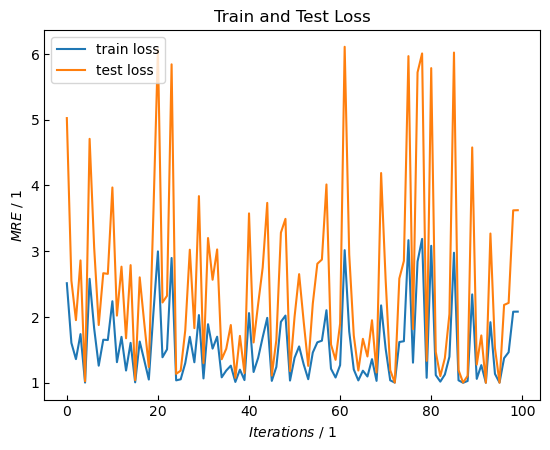

In [9]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_loss, label='train loss')
ax.plot(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Iterations$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.show()

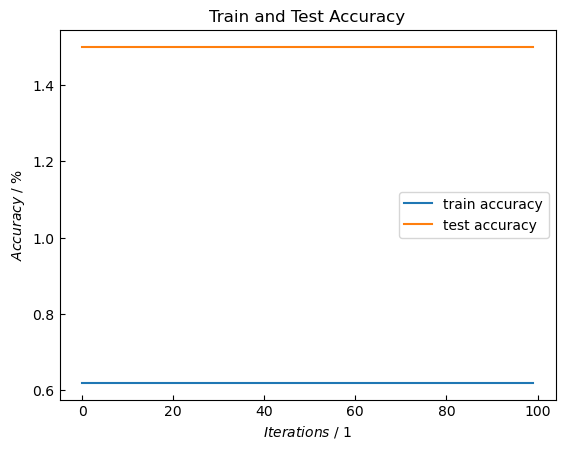

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Iterations$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.show()